In [75]:
import math
import numpy as np
from cv2 import Rodrigues
from math import sin, cos, atan2, sqrt
import pandas as pd
from pathlib import Path
import pyproj
from sklearn.preprocessing import StandardScaler
from pyproj import Proj, transform
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.metrics import accuracy_score
import lightgbm as lgb
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore", category=Warning)

In [76]:
df=pd.read_csv("/kaggle/input/th1-gaussion/Gia SMP va SMPcap 2021(Gi th trng SMP).csv", encoding='ISO-8859-1', delimiter=';')
df.head()

,Ngày,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,01/01/2021,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,...,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4
1,01/02/2021,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,...,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7
2,01/03/2021,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,...,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4
3,01/04/2021,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.1,...,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8
4,01/05/2021,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,...,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5


In [77]:
feats = ['16','17','18']

In [78]:
df[feats].head(10)

,16,17,18
0,964.4,964.4,964.4
1,1019.7,1019.7,1019.7
2,988.4,988.4,988.4
3,1010.8,1010.8,1010.8
4,1061.5,1061.5,1061.5
5,1061.5,1061.5,1061.5
6,1061.5,1061.5,1061.5
7,1061.5,1061.5,1061.5
8,1064.1,1064.1,1064.1
9,966.7,966.7,966.7


In [79]:
df[feats].isna().mean()

16    0.0
17    0.0
18    0.0
dtype: float64

In [80]:
import plotly.express as px
fig = px.line(y=df['16'], x=df['Ngày'])
fig.update_traces(line_color='black') 
fig.update_layout(xaxis_title="Ngày", 
                  yaxis_title="Cột 16",
                  title={'text': "Data", 'y':0.95, 'x':0.5, 'xanchor':'center', 'yanchor':'top'},
                  plot_bgcolor='rgba(53,223,0,0.8)')

In [81]:
import plotly.express as px
fig = px.line(y=df['17'], x=df['Ngày'])
fig.update_traces(line_color='black') 
fig.update_layout(xaxis_title="Ngày", 
                  yaxis_title="Cột 17",
                  title={'text': "Data", 'y':0.95, 'x':0.5, 'xanchor':'center', 'yanchor':'top'},
                  plot_bgcolor='rgba(53,223,0,0.8)')

In [82]:
import plotly.express as px
fig = px.line(y=df['18'], x=df['Ngày'])
fig.update_traces(line_color='black') 
fig.update_layout(xaxis_title="Ngày", 
                  yaxis_title="Cột 18",
                  title={'text': "Data", 'y':0.95, 'x':0.5, 'xanchor':'center', 'yanchor':'top'},
                  plot_bgcolor='rgba(53,223,0,0.8)')

In [83]:
transformer = StandardScaler()
X = transformer.fit_transform(np.array(df[feats]))

In [84]:
X[:5]

array([[-0.72311218, -0.72310607, -0.72309985],
       [-0.1964422 , -0.19643864, -0.19643315],
       [-0.49453931, -0.49453431, -0.49452841],
       [-0.28120464, -0.28120067, -0.28119506],
       [ 0.20165554,  0.20165717,  0.20166211]])

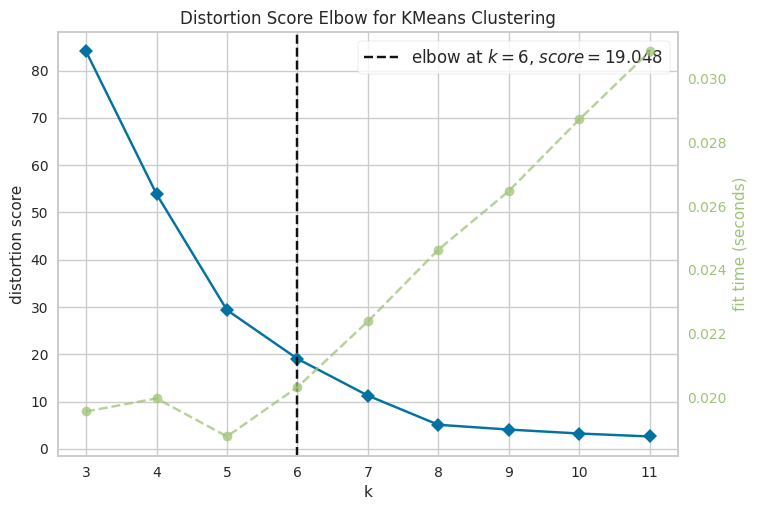

In [85]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

Elbow_M = KElbowVisualizer(KMeans(random_state=23), k=(3,12))
Elbow_M.fit(X)
Elbow_M.show();

In [86]:
from sklearn.mixture import BayesianGaussianMixture
BGM = BayesianGaussianMixture(n_components=6,covariance_type='full',random_state=1,n_init=12)
preds = BGM.fit_predict(X)
df["Clusters"]= preds

In [87]:
pp=BGM.predict_proba(X)
df_new=pd.DataFrame(X,columns=feats) 
df_new[[f'predict_proba_{i}' for i in range(6)]]=pp 
df_new['preds']=preds
df_new['predict_proba']=np.max(pp,axis=1)
df_new['predict']=np.argmax(pp,axis=1)
    
train_index=np.array([])
for n in range(6):
    n_inx=df_new[(df_new.preds==n) & (df_new.predict_proba > 0.5)].index
    train_index = np.concatenate((train_index, n_inx))

In [88]:
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
X_new=df_new.loc[train_index][feats]
y=df_new.loc[train_index]['preds']

params_lgb = {'learning_rate': 0.06,'objective': 'multiclass','boosting': 'gbdt','n_jobs': -1,'verbosity': -1, 'num_classes':7} 

model_list=[]

gkf = StratifiedKFold(5)
for fold, (train_idx, valid_idx) in enumerate(gkf.split(X_new,y)):   

    tr_dataset = lgb.Dataset(X_new.iloc[train_idx],y.iloc[train_idx],feature_name = feats)
    vl_dataset = lgb.Dataset(X_new.iloc[valid_idx],y.iloc[valid_idx],feature_name = feats)
    
    model = lgb.train(params = params_lgb, 
                train_set = tr_dataset, 
                valid_sets =  vl_dataset, 
                num_boost_round = 5000, 
                callbacks=[ lgb.early_stopping(stopping_rounds=300, verbose=False), lgb.log_evaluation(period=200)])  
    
    model_list.append(model) 

[200]	valid_0's multi_logloss: 0.244261
[200]	valid_0's multi_logloss: 0.000227283
[400]	valid_0's multi_logloss: 0.000226979
[600]	valid_0's multi_logloss: 0.000226889
[800]	valid_0's multi_logloss: 0.000226848
[1000]	valid_0's multi_logloss: 0.000226825
[1200]	valid_0's multi_logloss: 0.00022681
[1400]	valid_0's multi_logloss: 0.000226799
[1600]	valid_0's multi_logloss: 0.000226792
[1800]	valid_0's multi_logloss: 0.000226786
[2000]	valid_0's multi_logloss: 0.000226781
[2200]	valid_0's multi_logloss: 0.000226778
[2400]	valid_0's multi_logloss: 0.000226775
[2600]	valid_0's multi_logloss: 0.000226772
[2800]	valid_0's multi_logloss: 0.00022677
[3000]	valid_0's multi_logloss: 0.000226768
[3200]	valid_0's multi_logloss: 0.000226766
[3400]	valid_0's multi_logloss: 0.000226765
[3600]	valid_0's multi_logloss: 0.000226764
[3800]	valid_0's multi_logloss: 0.000226763
[4000]	valid_0's multi_logloss: 0.000226762
[4200]	valid_0's multi_logloss: 0.000226761
[4400]	valid_0's multi_logloss: 0.00022676

In [89]:
lgb_preds=0
for model in model_list:
    lgb_preds+=model.predict(df_new[feats])

In [90]:
labels=np.argmax(lgb_preds,axis=1)

In [91]:
u = np.unique(labels)
u

array([0, 1, 2, 3])

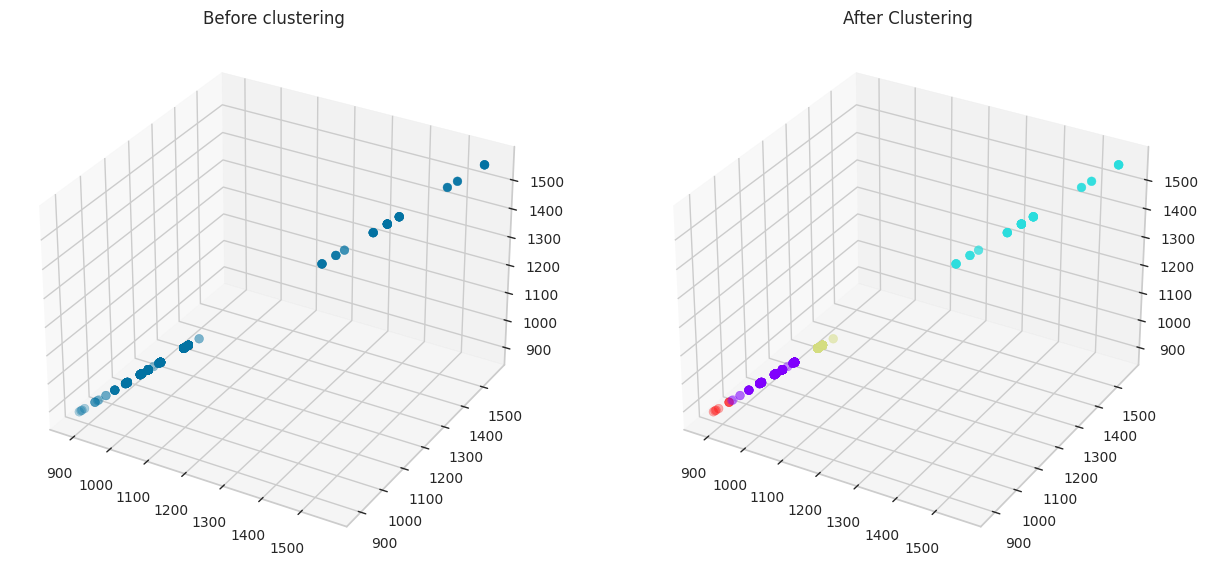

In [93]:
fig = plt.figure(figsize=(15,8))
ax = plt.subplot(1,2,1, projection='3d', label="bla")
ax.scatter(df['16'], df['17'],df['18'], s=40, marker='o', cmap = 'rainbow' )
ax.set_title("Before clustering")
ax = plt.subplot(1,2,2, projection='3d', label="bla")
ax.scatter(df['16'], df['17'],df['18'], s=40, c=df["Clusters"], marker='o',cmap="rainbow")
ax.set_title("After Clustering")
plt.show()

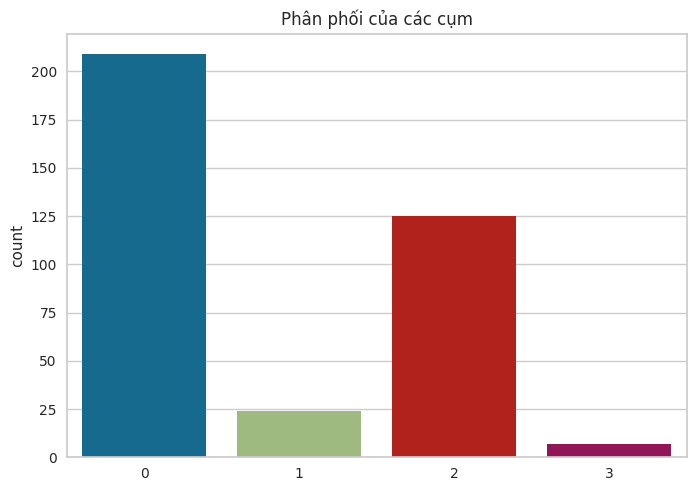

In [94]:
import seaborn as sns
pl = sns.countplot(x=np.argmax(lgb_preds,axis=1))
pl.set_title("Phân phối của các cụm")
plt.show()

In [98]:
from pykalman import KalmanFilter
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Lấy dữ liệu cột 7, 8, 9
observations = df[feats].values

# Định nghĩa mô hình Kalman Filter
kf = KalmanFilter(initial_state_mean=np.mean(observations, axis=0),
                  n_dim_obs=3)

# Ước lượng trạng thái
state_means, state_covariances = kf.em(observations).filter(observations)

In [99]:
# Tính toán các chỉ số đánh giá
for i, col in enumerate(feats):
    mse = mean_squared_error(observations[:, i], state_means[:, i])
    mae = mean_absolute_error(observations[:, i], state_means[:, i])
    rmse = np.sqrt(mse)
    print(f'Column {col} - MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}')

Column 16 - MSE: 293.5272, MAE: 10.2971, RMSE: 17.1326
Column 17 - MSE: 293.5344, MAE: 10.2975, RMSE: 17.1328
Column 18 - MSE: 293.5359, MAE: 10.2976, RMSE: 17.1329


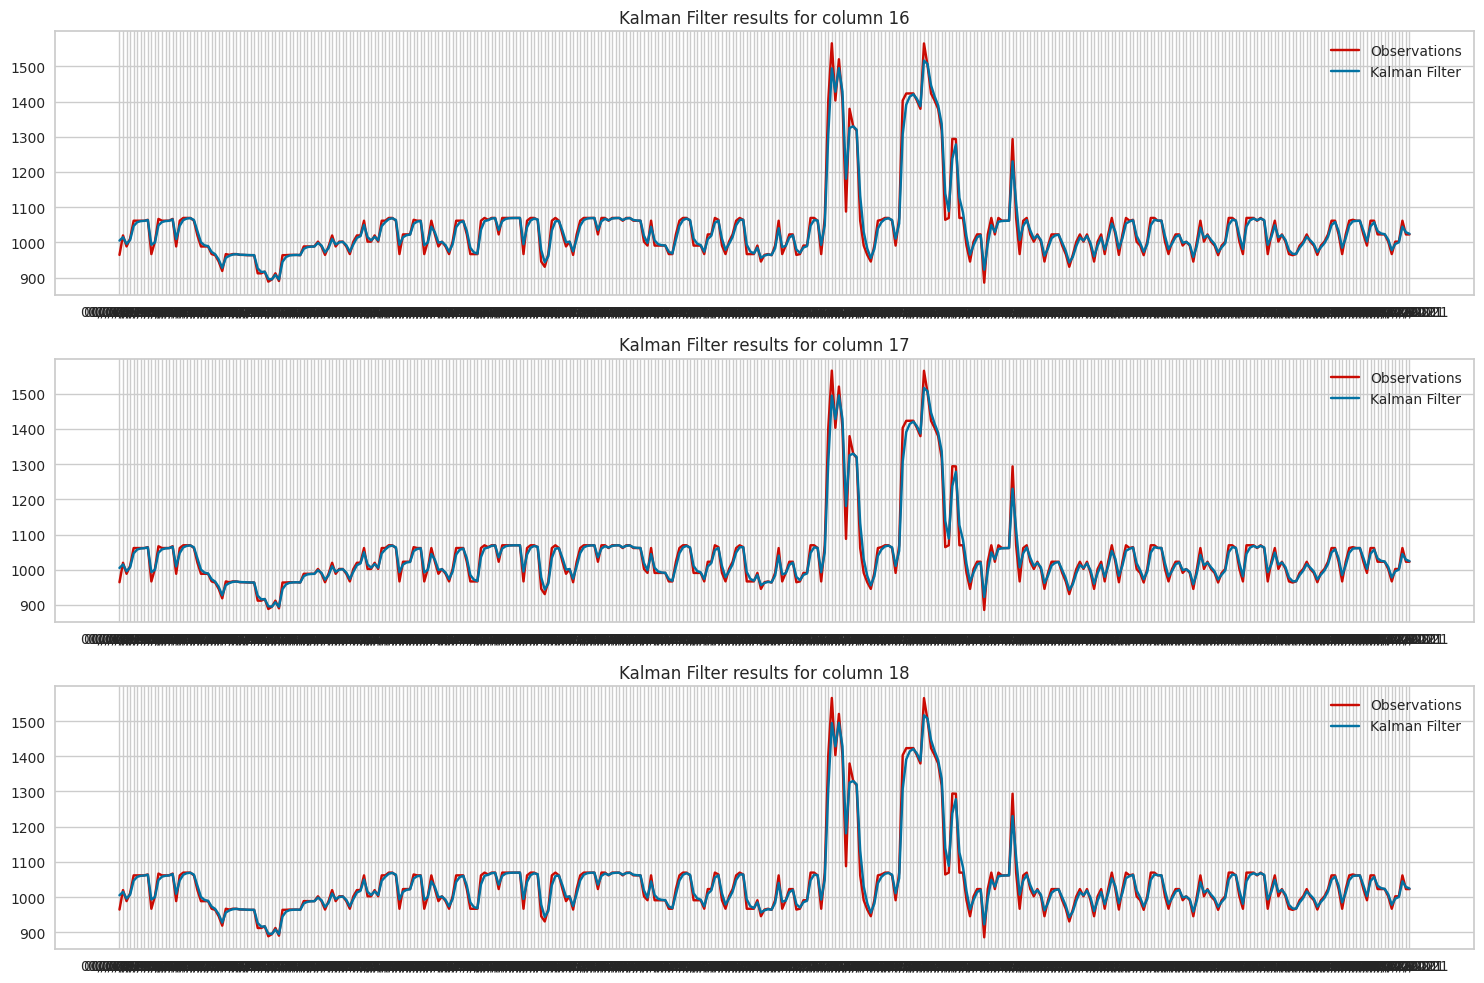

In [101]:
# Trực quan hóa kết quả cho từng cột
plt.figure(figsize=(15, 10))

for i, col in enumerate(feats):
    plt.subplot(len(feats), 1, i+1)
    plt.plot(df['Ngày'], observations[:, i], 'r', label='Observations')
    plt.plot(df['Ngày'], state_means[:, i], 'b', label='Kalman Filter')
    plt.title(f'Kalman Filter results for column {col}')
    plt.legend()

plt.tight_layout()
plt.show()